# ATLAS Open Data H>ZZ* with ServiceX, coffea, cabinetry & pyhf

In [1]:
import asyncio
import os
import re
import time

import awkward as ak
import cabinetry
from coffea.processor import servicex
from func_adl import ObjectStream
from func_adl_servicex import ServiceXSourceUpROOT
import hist
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import pyhf
from servicex.servicex import ServiceXDataset
import uproot

import utils
from utils import infofile  # contains cross-section information

utils.clean_up()  # delete output from previous runs of notebook (optional)
utils.set_logging()

## Introduction

We are going to use the ATLAS Open Data for this demonstration, in particular a H>ZZ* analysis. Find more information on the [ATLAS Open Data documentation](http://opendata.atlas.cern/release/2020/documentation/physics/FL2.html) and in [ATL-OREACH-PUB-2020-001](https://cds.cern.ch/record/2707171). The datasets used are [10.7483/OPENDATA.ATLAS.2Y1T.TLGL](http://doi.org/10.7483/OPENDATA.ATLAS.2Y1T.TLGL). The material in this notebook is based on the [ATLAS Open Data notebooks](https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata), a [PyHEP 2021 ServiceX demo](https://github.com/gordonwatts/pyhep-2021-SX-OpenDataDemo), and [Storm Lin's adoption](https://github.com/stormsomething/CoffeaHZZAnalysis) of this analysis.

This notebook is meant as a **technical demonstration**. In particular, the systematic uncertainties defined are purely to demonstrate aspects of realistic workflows, and are not meant to be meaningful physically. The fit performed to data consequently also only demonstrate technical aspects. If you are interested about the physics of H>ZZ*, check out for example the actual ATLAS cross-section measurement: [Eur. Phys. J. C 80 (2020) 942](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/HIGG-2018-29/).

This notebook implements most of the analysis pipeline shown in the following picture, using the tools also mentioned there:
![pict](https://iris-hep.org/assets/images/cabinetry-vertical-slice.png)

In particular, it performs:
- data delivery with `ServiceX`
- event / column selection with `func_adl`
- data handling with `awkward-array`
- histogram production with `coffea`
- histogram handling with `hist`
- visualization with `mplhep` & `hist`
- ROOT file handling with `uproot`
- statistical model construction with `cabinetry`
- statistical inference with `pyhf`

In [2]:
prefix = (
    "root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2020-01-22/4lep/"
)

fileset = {
    "Data": [
        prefix + "Data/data_A.4lep.root",
        prefix + "Data/data_B.4lep.root",
        prefix + "Data/data_C.4lep.root",
        prefix + "Data/data_D.4lep.root",
    ],
    "Background $Z,tt^{bar}$": [
        prefix + "MC/mc_361106.Zee.4lep.root",
        prefix + "MC/mc_361107.Zmumu.4lep.root",
        prefix + "MC/mc_410000.ttbar_lep.4lep.root",
    ],
    "Background $ZZ^{star}$": [prefix + "MC/mc_363490.llll.4lep.root"],
    "Signal ($m_H$ = 125 GeV)": [
        prefix + "MC/mc_345060.ggH125_ZZ4lep.4lep.root",
        prefix + "MC/mc_344235.VBFH125_ZZ4lep.4lep.root",
        prefix + "MC/mc_341964.WH125_ZZ4lep.4lep.root",
        prefix + "MC/mc_341947.ZH125_ZZ4lep.4lep.root",
    ],
}

# information for histograms
bin_edge_low = 80  # 80 GeV
bin_edge_high = 250  # 250 GeV
num_bins = 34

## Setting up a query with `func_adl`

We are using `func_adl` for event & column selection, and make a datasource with the query built by `get_lepton_query`.

A list of all available columns in the input files can be found in the [ATLAS documentation of branches](http://opendata.atlas.cern/release/2020/documentation/datasets/dataset13.html).

<span style="color:darkgreen">**Systematic uncertainty:**</span> scale factor variation, applied already at event selection stage. Imagine that this could be a calculation that requires a lot of different variables which are no longer needed downstream afterwards, so it makes sense to do it here.

In [3]:
def get_lepton_query(source: ObjectStream) -> ObjectStream:
    """Performs event selection: require events with exactly four leptons.
    Also select all columns needed further downstream for processing &
    & histogram filling.
    """
    return source.Where(lambda e: e.lep_n == 4).Select(
        lambda e: {
            "lep_pt": e.lep_pt,
            "lep_eta": e.lep_eta,
            "lep_phi": e.lep_phi,
            "lep_energy": e.lep_E,
            "lep_charge": e.lep_charge,
            "lep_typeid": e.lep_type,
            "mcWeight": e.mcWeight,
            "scaleFactor": e.scaleFactor_ELE
            * e.scaleFactor_MUON
            * e.scaleFactor_LepTRIGGER
            * e.scaleFactor_PILEUP,
            # scale factor systematic variation example
            "scaleFactorUP": e.scaleFactor_ELE
            * e.scaleFactor_MUON
            * e.scaleFactor_LepTRIGGER
            * e.scaleFactor_PILEUP
            * 1.1,
            "scaleFactorDOWN": e.scaleFactor_ELE
            * e.scaleFactor_MUON
            * e.scaleFactor_LepTRIGGER
            * e.scaleFactor_PILEUP
            * 0.9,
        }
    )


def make_datasource(name: str, query: ObjectStream):
    """Creates a ServiceX datasource for a particular ATLAS Open data file."""
    datasets = [ServiceXDataset(fileset[name], backend_name="uproot")]
    return servicex.DataSource(
        query=query, metadata={"dataset_category": name}, datasets=datasets
    )

## Processing `ServiceX`-provided data with `coffea`

Event weighting: look up cross-section from a provided utility file, and correctly normalize all events.

In [4]:
def get_xsec_weight(sample: str) -> float:
    """Returns normalization weight for a given sample."""
    lumi = 10_000  # pb^-1
    xsec_map = infofile.infos[sample]  # dictionary with event weighting information
    xsec_weight = (lumi * xsec_map["xsec"]) / (xsec_map["sumw"] * xsec_map["red_eff"])
    return xsec_weight

Cuts to apply:
- two opposite flavor leptons (total lepton charge is 0)
- lepton types: 4 electrons, 4 muons, or 2 electrons + 2 muons

In [5]:
def lepton_filter(lep_charge, lep_type):
    """Filters leptons: sum of charges is required to be 0, and sum of lepton types 44/48/52.
    Electrons have type 11, muons have 13, so this means 4e/4mu/2e2mu.
    """
    sum_lep_charge = (
        lep_charge[:, 0] + lep_charge[:, 1] + lep_charge[:, 2] + lep_charge[:, 3]
    )
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] + lep_type[:, 2] + lep_type[:, 3]
    good_lep_type = ak.any(
        [sum_lep_type == 44, sum_lep_type == 48, sum_lep_type == 52], axis=0
    )
    return ak.all([sum_lep_charge == 0, good_lep_type], axis=0)

Set up the `coffea` processor. It will apply cuts, calculate the four-lepton invariant mass, and fill a histogram.

<span style="color:darkgreen">**Systematic uncertainty:**</span> m4l variation, applied in the processor to remaining events. This might for example be the result of applying a tool performing a computationally expensive calculation, which should only be run for events where it is needed.

In [6]:
class HZZAnalysis(servicex.Analysis):
    """The coffea processor used in this analysis."""

    def process(self, events):
        # type of dataset being processed, provided via metadata (comes originally from fileset)
        dataset_category = events.metadata["dataset_category"]

        # get lepton information from events
        leptons = events.lep

        # apply a cut to events, based on lepton charge and lepton type
        events = events[lepton_filter(leptons.charge, leptons.typeid)]
        leptons = events.lep

        # calculate the 4-lepton invariant mass for each remaining event
        # this could also be an expensive calculation using external tools
        mllll = (
            leptons[:, 0] + leptons[:, 1] + leptons[:, 2] + leptons[:, 3]
        ).mass / 1000

        # creat histogram holding outputs, for data just binned in m4l
        mllllhist_data = hist.Hist.new.Reg(
            num_bins,
            bin_edge_low,
            bin_edge_high,
            name="mllll",
            label="$\mathrm{m_{4l}}$ [GeV]",
        ).Weight()  # using weighted storage here for plotting later, but not needed

        # three histogram axes for MC: m4l, category, and variation (nominal and
        # systematic variations)
        mllllhist_MC = (
            hist.Hist.new.Reg(
                num_bins,
                bin_edge_low,
                bin_edge_high,
                name="mllll",
                label="$\mathrm{m_{4l}}$ [GeV]",
            )
            .StrCat(
                [
                    "Background $Z,tt^{bar}$",
                    "Background $ZZ^{star}$",
                    "Signal ($m_H$ = 125 GeV)",
                ],
                name="dataset",
            )
            .StrCat(
                ["nominal", "scaleFactorUP", "scaleFactorDOWN", "m4lUP", "m4lDOWN"],
                name="variation",
            )
            .Weight()
        )

        if dataset_category == "Data":
            # create and fill a histogram for m4l
            mllllhist_data.fill(mllll=mllll)

        else:
            # extract the sample name from the filename to calculate x-sec weight
            sample = re.findall(r"mc_\d+\.(.+)\.4lep", events.metadata["filename"])[0]
            basic_weight = get_xsec_weight(sample) * events.mcWeight
            totalWeights = basic_weight * events.scaleFactor

            # calculate systematic variations for weight
            totalWeightsUp = basic_weight * events.scaleFactorUP
            totalWeightsDown = basic_weight * events.scaleFactorDOWN

            # create and fill weighted histograms for m4l: nominal and variations
            mllllhist_MC.fill(
                mllll=mllll,
                dataset=dataset_category,
                variation="nominal",
                weight=totalWeights,
            )

            # scale factor variations
            mllllhist_MC.fill(
                mllll=mllll,
                dataset=dataset_category,
                variation="scaleFactorUP",
                weight=totalWeightsUp,
            )
            mllllhist_MC.fill(
                mllll=mllll,
                dataset=dataset_category,
                variation="scaleFactorDOWN",
                weight=totalWeightsDown,
            )

            # variation in 4-lepton invariant mass
            mllllhist_MC.fill(
                mllll=mllll * 1.01,
                dataset=dataset_category,
                variation="m4lUP",
                weight=totalWeights,
            )
            mllllhist_MC.fill(
                mllll=mllll * 0.99,
                dataset=dataset_category,
                variation="m4lDOWN",
                weight=totalWeights,
            )

        return {"data": mllllhist_data, "MC": mllllhist_MC}

## Producing the desired histograms

Putting everything together: query, datasource, processor, this function runs everything so far and collects the produced histograms.

In [7]:
async def produce_all_histograms():
    """Run on a known analysis file/files and return the result.
    Should be fine to start many of these at once.
    """
    # Create the query
    ds = ServiceXSourceUpROOT("cernopendata://dummy", "mini", backend_name="uproot")
    ds.return_qastle = True
    lepton_query = get_lepton_query(ds)

    executor = servicex.LocalExecutor()
    # To run with the Dask executor on coffea-casa, use the following:
    # (please note https://github.com/CoffeaTeam/coffea/issues/611)
    #     if os.environ.get("LABEXTENTION_FACTORY_MODULE") == "coffea_casa":
    #         executor = servicex.DaskExecutor(client_addr="tls://localhost:8786")

    datasources = [make_datasource(ds_name, lepton_query) for ds_name in fileset.keys()]

    # Create the analysis processor
    analysis_processor = HZZAnalysis()

    async def run_updates_stream(accumulator_stream, name):
        """Run to get the last item in the stream"""
        coffea_info = None
        try:
            async for coffea_info in accumulator_stream:
                pass
        except Exception as e:
            raise Exception(f"Failure while processing {name}") from e
        return coffea_info

    all_histogram_dicts = await asyncio.gather(
        *[
            run_updates_stream(
                executor.execute(analysis_processor, source),
                source.metadata["dataset_category"],
            )
            for source in datasources
        ]
    )
    full_data_histogram = sum([h["data"] for h in all_histogram_dicts])
    full_mc_histogram = sum([h["MC"] for h in all_histogram_dicts])

    return {"data": full_data_histogram, "MC": full_mc_histogram}

Now run the function just defined: obtain data from ServiceX, run processor, gather output histogram.

In [8]:
t0 = time.time()

# in a notebook:
output = await produce_all_histograms()

# as a script:
# async def produce_all_the_histograms():
#    return await produce_all_histograms()
#
# output = asyncio.run(produce_all_the_histograms())

print(f"execution took {time.time() - t0:.2f} seconds")

execution took 9.22 seconds


## Plotting histograms with `mplhep` and `hist` & `matplotlib`

We can plot some of the histograms we just produced with `mplhep`, `hist` & `matplotlib`.

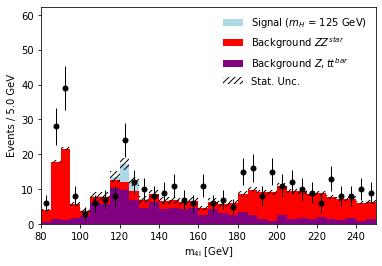

In [9]:
# plot histograms with mplhep & hist
mplhep.histplot(output["data"], histtype="errorbar", color="black")
hist.Hist.plot1d(
    output["MC"][:, :, "nominal"],
    stack=True,
    histtype="fill",
    color=["purple", "red", "lightblue"],
)

# bin parameters
step_size = (bin_edge_high - bin_edge_low) / num_bins
bin_centers = output["data"].axes[0].centers

# calculate background statistical uncertainty
mc_histogram_sum = output["MC"][:, :, "nominal"].project("mllll").values()
mc_err = np.sqrt(output["MC"][:, :, "nominal"].project("mllll").variances())

# plot background statistical uncertainty
plt.bar(
    bin_centers,  # x
    2 * mc_err,  # heights
    alpha=0.5,  # half transparency
    bottom=mc_histogram_sum - mc_err,
    color="none",
    hatch="////",
    width=step_size,
    label="Stat. Unc.",
)

# tune plot appearance
main_axes = plt.gca()
main_axes.set_xlim(left=bin_edge_low, right=bin_edge_high)
main_axes.set_ylim(bottom=0, top=np.amax(output["data"].values()) * 1.6)
main_axes.set_ylabel("Events / " + str(step_size) + " GeV")
main_axes.legend(frameon=False);

## Saving histograms with uproot

In order to build a statistical model, we will use `cabinetry`'s support for reading histograms to build a so-called workspace specifying the model.
We will save the histograms we just created to disk with `uproot`.

In [10]:
file_name = "histograms.root"
with uproot.recreate(file_name) as f:
    f["data"] = output["data"]

    f["Z_tt"] = output["MC"][:, "Background $Z,tt^{bar}$", "nominal"]
    f["Z_tt_SF_up"] = output["MC"][:, "Background $Z,tt^{bar}$", "scaleFactorUP"]
    f["Z_tt_SF_down"] = output["MC"][:, "Background $Z,tt^{bar}$", "scaleFactorDOWN"]
    f["Z_tt_m4l_up"] = output["MC"][:, "Background $Z,tt^{bar}$", "m4lUP"]
    f["Z_tt_m4l_down"] = output["MC"][:, "Background $Z,tt^{bar}$", "m4lDOWN"]

    f["ZZ"] = output["MC"][:, "Background $ZZ^{star}$", "nominal"]
    f["ZZ_SF_up"] = output["MC"][:, "Background $ZZ^{star}$", "scaleFactorUP"]
    f["ZZ_SF_down"] = output["MC"][:, "Background $ZZ^{star}$", "scaleFactorDOWN"]
    f["ZZ_m4l_up"] = output["MC"][:, "Background $ZZ^{star}$", "m4lUP"]
    f["ZZ_m4l_down"] = output["MC"][:, "Background $ZZ^{star}$", "m4lDOWN"]

    f["signal"] = output["MC"][:, "Signal ($m_H$ = 125 GeV)", "nominal"]
    f["signal_SF_up"] = output["MC"][:, "Signal ($m_H$ = 125 GeV)", "scaleFactorUP"]
    f["signal_SF_down"] = output["MC"][:, "Signal ($m_H$ = 125 GeV)", "scaleFactorDOWN"]
    f["signal_m4l_up"] = output["MC"][:, "Signal ($m_H$ = 125 GeV)", "m4lUP"]
    f["signal_m4l_down"] = output["MC"][:, "Signal ($m_H$ = 125 GeV)", "m4lDOWN"]

## Building a workspace and running a fit with cabinetry & pyhf

<span style="color:darkgreen">**Systematic uncertainty:**</span> ZZ normalization, not requiring any histograms

In [11]:
config = cabinetry.configuration.load("config.yml")
cabinetry.templates.collect(config)
cabinetry.templates.postprocess(config)
ws = cabinetry.workspace.build(config)

INFO - cabinetry.configuration - opening config file config.yml
INFO - cabinetry.workspace - building workspace


Create a `pyhf` model and extract the data from the workspace. Perform a MLE fit, and produce the post-fit model prediction.

In [12]:
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)
postfit_model = cabinetry.model_utils.prediction(model, fit_results=fit_results)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 81.38                      │             Nfcn = 2335              │
│ EDM = 5.82e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

We can visualize the pulls and correlations.

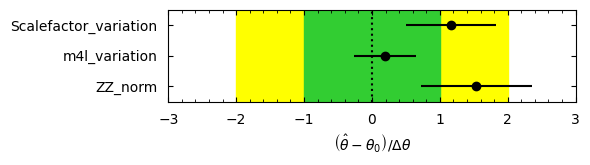

In [13]:
cabinetry.visualize.pulls(fit_results, exclude="Signal_norm")

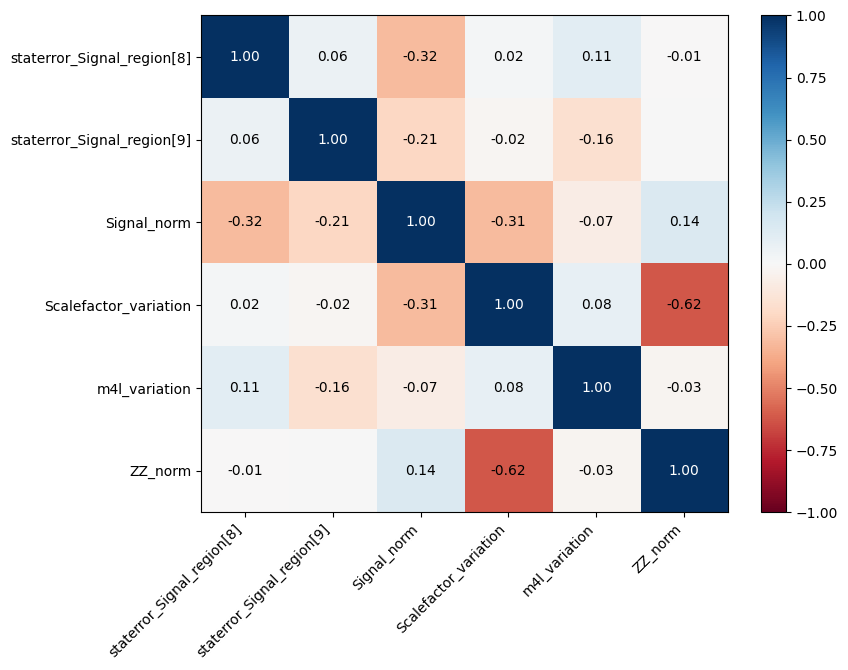

In [14]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.15)

Finally, visualize the post-fit model and data. This is done using information stored in the workspace, which does not include binning or which observable is used. This information can be passed in via the `config` kwarg, but we can also edit the figure after its creation. We will demonstrate both below.

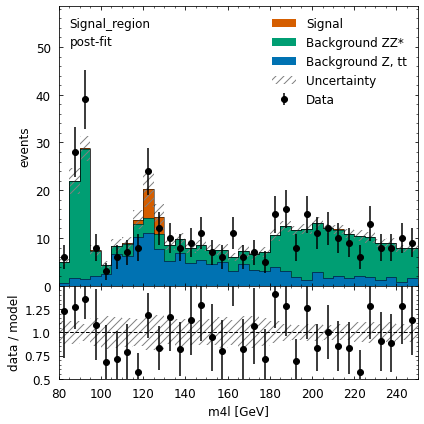

In [15]:
# binning to use in plot
plot_config = {
    "Regions": [
        {
            "Name": "Signal_region",
            "Binning": list(np.linspace(bin_edge_low, bin_edge_high, num_bins + 1)),
        }
    ]
}

figure_dict = cabinetry.visualize.data_mc(
    postfit_model, data, config=plot_config, close_figure=True
)

# modify x-axis label
figure_dict[0]["figure"].axes[1].set_xlabel("m4l [GeV]")

# show the modified figure
figure_dict[0]["figure"]

We can also use `pyhf` directly. We already have a model and data, so let's calculate the CLs value.

In [16]:
mu_test = 1.0
cls = float(pyhf.infer.hypotest(mu_test, data, model))
print(f"CL_S for Signal_norm={mu_test} is {cls:.3f}")

CL_S for Signal_norm=1.0 is 0.535


## Exercises

Here are a few ideas to try out to become more familiar with the tools shown in this notebook:

- Run the notebook a second time. It should be faster now — you are taking advantage of caching!
- Change the event pre-selection in the `func_adl` query. Try out requiring exactly zero jets. Has the analysis become more or less sensitive after this change?
- Change the lepton requirements. What happens when only accepting events with 4 electrons or 4 muons?
- Try a different binning. Note how you still benefit from caching in the `ServiceX`-delivered data!
- Compare the pre- and post-fit data/MC agreement (hint: the `fit_results` kwarg in `cabinetry.model_utils.prediction` is optional).
- Find the value of the `Signal_norm` normalization factor for which CL_S = 0.05, the 95% confidence level upper parameter limit (hint: use `pyhf` directly, or `cabinetry.fit.limit`).


Advanced ideas:
- Implement a more realistic systematic uncertainty in the `coffea` processor, for example for detector-related uncertainties for lepton kinematics. Propagate it through the analysis chain to observe the impact in a ranking plot produced with `cabinetry`.
- Try out this workflow with your own analysis! Are there missing features or ways to streamline the experience? If so, please let us know!